In [ ]:
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import string

nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """Перетворює теги Penn Treebank на теги, які розуміє WordNetLemmatizer."""
    if treebank_tag.startswith('J'):
        return 'a' 
    elif treebank_tag.startswith('V'):
        return 'v' 
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r' 
    else:
        return 'n' 

def preprocess_text(corpus_sents):
    """
    Функція для повної попередньої обробки корпусу:
    токенізація, видалення пунктуації, стоп-слів та лематизація.
    """
    processed_corpus = []
    for sent in corpus_sents:
        tokens = [word.lower() for word in sent if word.isalpha()]
        tagged_tokens = pos_tag(tokens)
        
        lemmatized_sent = []
        for word, tag in tagged_tokens:
            if word not in stop_words:
                wn_tag = get_wordnet_pos(tag)
                lemmatized_sent.append(lemmatizer.lemmatize(word, wn_tag))
        
        if lemmatized_sent:
            processed_corpus.append(lemmatized_sent)
            
    return processed_corpus

corpus_sents = gutenberg.sents('austen-emma.txt')
preprocessed_corpus = preprocess_text(corpus_sents)

print(f"Корпус оброблено. Кількість речень: {len(preprocessed_corpus)}")
print(f"Приклад обробленого речення: {preprocessed_corpus[10]}")

Корпус оброблено. Кількість речень: 7673
Приклад обробленого речення: ['danger', 'however', 'present', 'unperceived', 'mean', 'rank', 'misfortune']


# TASK 0

In [ ]:
from gensim.models import Word2Vec

print("\nНавчання моделі Word2Vec...")
custom_model = Word2Vec(
    sentences=preprocessed_corpus,
    vector_size=100,  
    window=5,        
    min_count=5,   
    workers=4        
)
print("Модель успішно навчено.")

custom_vectors = custom_model.wv
print(f"Розмір словника моделі: {len(custom_vectors.index_to_key)}")


Навчання моделі Word2Vec...
Модель успішно навчено.
Розмір словника моделі: 1847


# TASK 1

In [ ]:
print("\n--- Практика використання моделі ---")

word_to_check = 'emma'
if word_to_check in custom_vectors:
    similar_words = custom_vectors.most_similar(word_to_check, topn=5)
    print(f"Найбільш схожі слова на '{word_to_check}': {similar_words}")

word1, word2 = 'mr', 'mrs'
if word1 in custom_vectors and word2 in custom_vectors:
    similarity = custom_vectors.similarity(word1, word2)
    print(f"Подібність між '{word1}' та '{word2}': {similarity:.2f}")

word_list = ['father', 'mother', 'sister', 'house']
if all(word in custom_vectors for word in word_list):
    odd_one_out = custom_vectors.doesnt_match(word_list)
    print(f"Зайве слово у списку {word_list}: '{odd_one_out}'")

word3, word4 = 'happy', 'sad'
if word3 in custom_vectors and word4 in custom_vectors:
    distance = custom_vectors.distance(word3, word4)
    print(f"Відстань між '{word3}' та '{word4}': {distance:.2f}")


--- Практика використання моделі ---
Найбільш схожі слова на 'emma': [('way', 0.9995956420898438), ('nothing', 0.9995617866516113), ('still', 0.9995567202568054), ('old', 0.9995344281196594), ('however', 0.9995319843292236)]
Подібність між 'mr' та 'mrs': 1.00
Зайве слово у списку ['father', 'mother', 'sister', 'house']: 'sister'
Відстань між 'happy' та 'sad': 0.00


# TASK 2


--- Візуалізація відстаней між документами ---


IndexError: index 14 is out of bounds for axis 0 with size 14

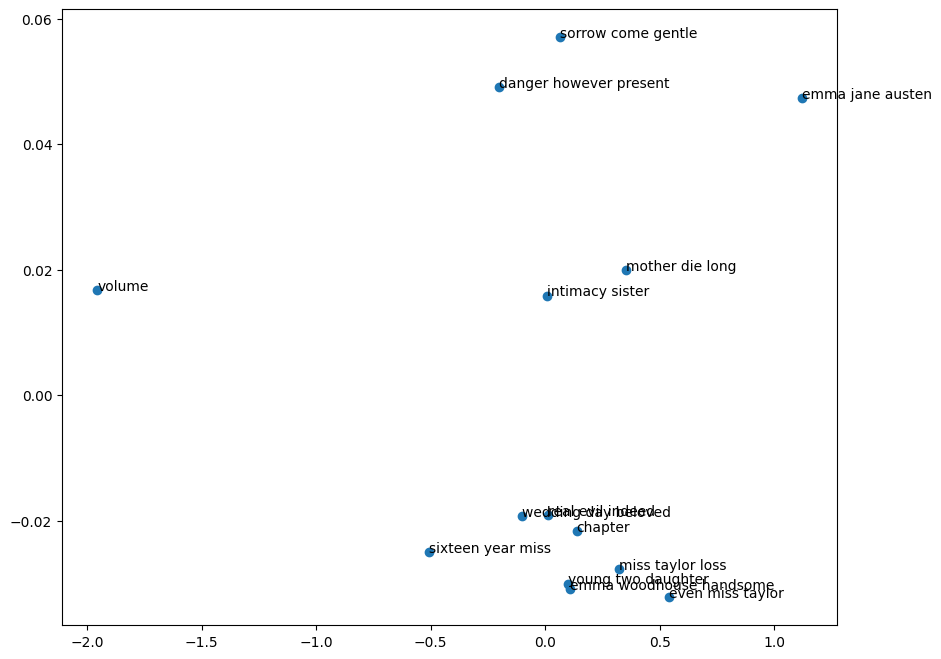

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("\n--- Візуалізація відстаней між документами ---")

documents_to_plot = preprocessed_corpus[:15]

doc_vectors = []
for doc in documents_to_plot:
    vectors = [custom_vectors[word] for word in doc if word in custom_vectors]
    if vectors:
        doc_vectors.append(np.mean(vectors, axis=0))

pca = PCA(n_components=2)
doc_vectors_2d = pca.fit_transform(doc_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1])
for i, doc in enumerate(documents_to_plot):
    label = ' '.join(doc[:3])
    plt.annotate(label, (doc_vectors_2d[i, 0], doc_vectors_2d[i, 1]))

plt.title("Візуалізація документів (речень) у 2D-просторі")
plt.xlabel("Перша головна компонента")
plt.ylabel("Друга головна компонента")
plt.grid(True)
plt.show()

# TASK 3

In [ ]:
import gensim.downloader
from gensim.models import KeyedVectors

print("\n--- Порівняння моделей ---")

try:
    glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
except Exception as e:
    print(f"Не вдалося завантажити GloVe: {e}. Пропускаємо порівняння.")
    glove_vectors = None

if glove_vectors:
    try:
        wordsim353_path = 'wordsim353/combined.csv'
        evaluation_data = []
        with open(wordsim353_path, 'r') as f:
            next(f) 
            for line in f:
                parts = line.strip().split(',')
                evaluation_data.append((parts[0], parts[1], float(parts[2])))

        custom_eval = custom_vectors.evaluate_word_pairs(evaluation_data)
        print(f"Результати для власної моделі Word2Vec:")
        print(f"  Кореляція Пірсона: {custom_eval[0][0]:.4f}")
        print(f"  Кореляція Спірмена: {custom_eval[1][0]:.4f}")
        print(f"  Відсоток слів поза словником: {custom_eval[2] * 100:.2f}%")

        glove_eval = glove_vectors.evaluate_word_pairs(evaluation_data)
        print(f"\nРезультати для попередньо навченої моделі GloVe:")
        print(f"  Кореляція Пірсона: {glove_eval[0][0]:.4f}")
        print(f"  Кореляція Спірмена: {glove_eval[1][0]:.4f}")
        print(f"  Відсоток слів поза словником: {glove_eval[2] * 100:.2f}%")

    except FileNotFoundError:
        print("\nНе вдалося знайти датасет 'wordsim353'.")
        print("Будь ласка, завантажте його та розмістіть у папці 'wordsim353/combined.csv' для виконання порівняння.")


--- Порівняння моделей ---
[==================================================] 100.0% 66.0/66.0MB downloaded

Не вдалося знайти датасет 'wordsim353'.
Будь ласка, завантажте його та розмістіть у папці 'wordsim353/combined.csv' для виконання порівняння.
